In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize

import string, warnings, urllib3, locale

warnings.filterwarnings('ignore')
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

def nice_axes(ax):
    plt.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.1)
               , ncol = len(df.columns)
               , fancybox = False
               , shadow = True
               , fontsize = 20)

    [spine.set_visible(False) for spine in ax.spines.values()]

    ax.set_yticklabels([int(x) if x > 0 else '' for x in ax.get_yticks()])

    ax.tick_params(left = False, bottom = False)
    ax.grid(axis='y', alpha=0.25)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('')

 #   ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

In [3]:
url = 'https://es.wikipedia.org/wiki/ISO_3166-2:ES'
comunidades = {}

urllib3.disable_warnings()
http = urllib3.PoolManager()
response = http.request('GET', url)
soup = BeautifulSoup(response.data, 'html.parser')

for i in soup.find_all('tr'):
    if len(i.find_all('td')) == 2:
        k = str(i.find_all('td')[1].find_all('a')[0])
        comunidades[str(i.find_all('td')[0])[11:13]] = k[k.find('title') + 7:k.find('">')]

comunidades 

{'AN': 'Andalucía',
 'AR': 'Aragón',
 'AS': 'Asturias',
 'CN': 'Canarias',
 'CB': 'Cantabria',
 'CM': 'Castilla-La Mancha',
 'CL': 'Castilla y León',
 'CT': 'Cataluña',
 'EX': 'Extremadura',
 'GA': 'Galicia',
 'IB': 'Islas Baleares',
 'RI': 'La Rioja (España)',
 'MD': 'Comunidad de Madrid',
 'MC': 'Región de Murcia',
 'NC': 'Comunidad Foral de Navarra',
 'PV': 'País Vasco',
 'VC': 'Comunidad Valenciana',
 'CE': 'Ceuta',
 'ML': 'Melilla'}

## Poblacion

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review + '.' for review in comunidades.values()), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.Total = poblacion.Total.str.replace('.','').astype(int)

poblacion = poblacion.Total

poblacion

Comunidades y Ciudades Autónomas
Andalucía                     8464411
Aragón                        1329391
Asturias                      1018784
Islas Baleares                1171543
Canarias                      2175952
Cantabria                      582905
Castilla y León               2394918
Castilla-La Mancha            2045221
Cataluña                      7780479
Comunidad Valenciana          5057353
Extremadura                   1063987
Galicia                       2701819
Comunidad de Madrid           6779888
Región de Murcia              1511251
Comunidad Foral de Navarra     661197
País Vasco                    2220504
La Rioja (España)              319914
Ceuta                           84202
Melilla                         87076
Name: Total, dtype: int64

In [5]:
url = 'https://cnecovid.isciii.es/covid19/resources/casos_tecnica_ccaa.csv'
df = pd.read_csv(url)

df = (df
      .assign(ccaa_iso = df.ccaa_iso.map(comunidades))
      .set_index('ccaa_iso')
      .merge(poblacion, left_index=True, right_index=True)
      .reset_index()
      .set_index('fecha')
      .rename(columns = {'index': 'Comunidad'
                         , 'num_casos': 'Casos'}))

df[df.Comunidad == 'Comunidad Valenciana'].tail(15)['Casos']

fecha
2021-02-22    311
2021-02-23    355
2021-02-24    285
2021-02-25    283
2021-02-26    272
2021-02-27    162
2021-02-28    122
2021-03-01    166
2021-03-02    141
2021-03-03    148
2021-03-04    114
2021-03-05     84
2021-03-06     83
2021-03-07     68
2021-03-08      0
Name: Casos, dtype: int64

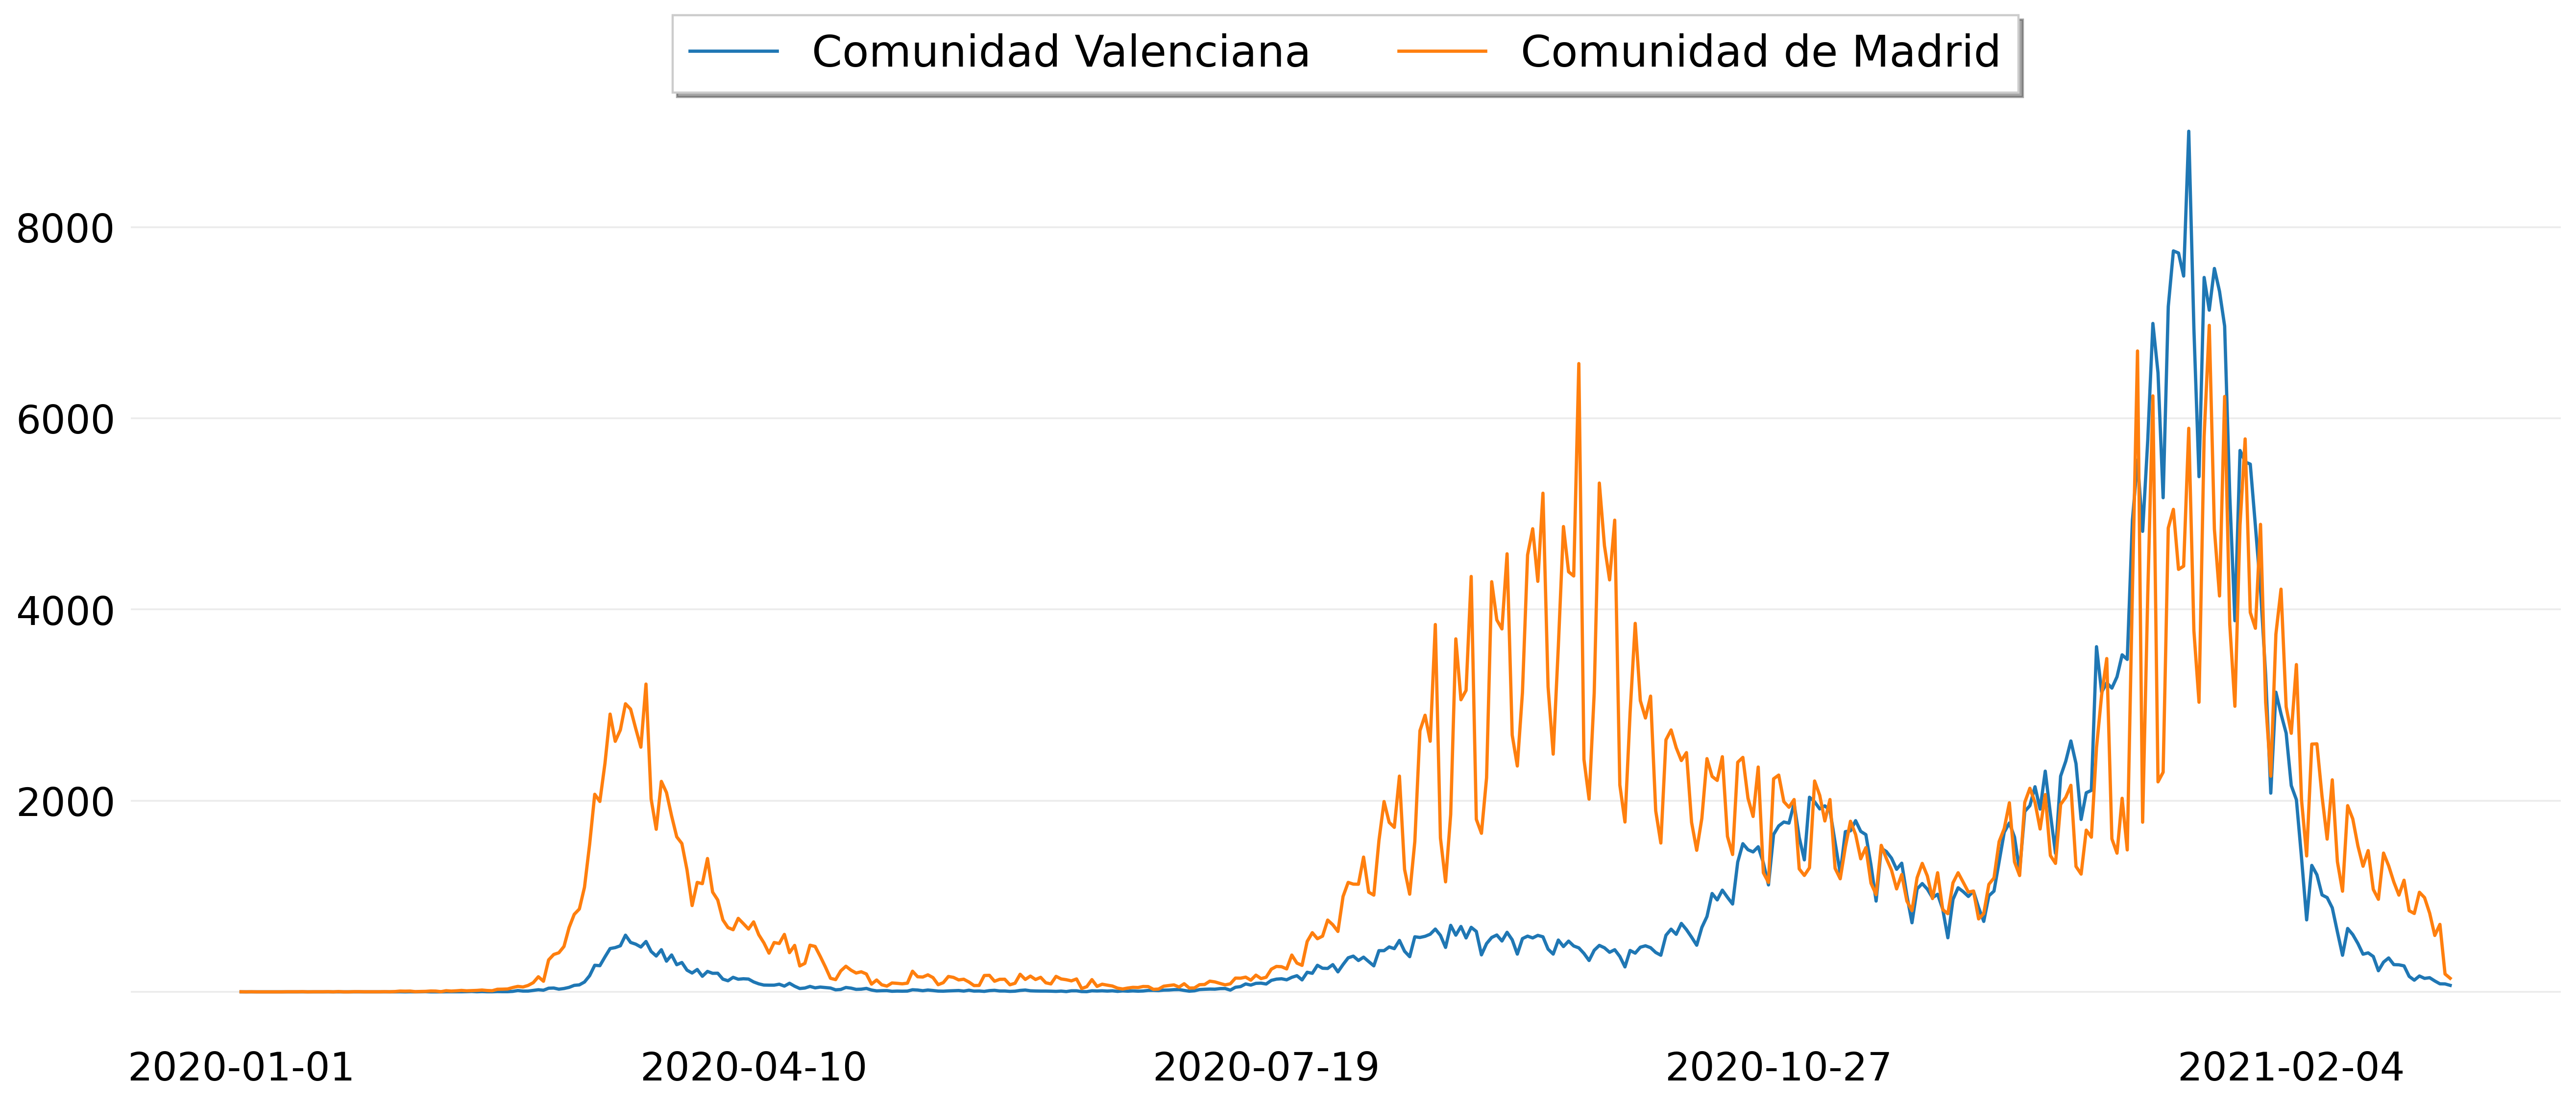

In [6]:
fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

series = ['Comunidad Valenciana', 'Comunidad de Madrid']
for i in series:
    df[df.Comunidad == i][:-1]['Casos'].plot(label = i)

nice_axes(ax)
plt.show()

In [7]:
df2 = (df
       .assign(Incidencia = lambda x: x.Casos / x.Total * 1e5)
       .pivot(columns='Comunidad', values = 'Incidencia')
       .rolling(14).sum()
      )[:-1]

df2.tail()

Comunidad,Andalucía,Aragón,Asturias,Canarias,Cantabria,Castilla y León,Castilla-La Mancha,Cataluña,Ceuta,Comunidad Foral de Navarra,Comunidad Valenciana,Comunidad de Madrid,Extremadura,Galicia,Islas Baleares,La Rioja (España),Melilla,País Vasco,Región de Murcia
fecha,,,,,,,,,,,,,,,,,,,
2021-03-03,126.399817,170.303545,190.324936,103.724715,107.221588,137.917039,87.129948,194.062602,283.841239,123.412538,71.934864,227.924119,49.436694,107.261071,55.397028,75.020162,378.979282,195.496158,81.985057
2021-03-04,123.777071,165.790200,191.797280,102.575792,104.648270,133.323980,80.675878,182.662276,286.216479,119.177794,66.398371,217.245477,46.711097,100.487857,52.068085,73.144658,382.424549,188.335621,79.139733
2021-03-05,120.847156,156.613066,180.509313,100.140077,96.585207,121.799577,74.221808,173.254115,279.090758,117.211663,59.991857,205.858858,42.481722,94.343848,48.568426,67.518146,367.495062,176.356359,73.250572
2021-03-06,116.074231,147.059819,165.982191,96.095870,88.522143,113.573826,69.136783,163.049087,276.715517,114.791809,54.316952,192.805545,39.944097,87.052464,45.580913,65.642641,349.120309,164.917514,68.883329
2021-03-07,109.978119,137.581795,151.160599,90.259344,80.630634,106.266686,65.176331,153.962243,264.839315,107.683489,51.291654,180.622453,36.842555,79.761079,42.166613,62.516801,326.151867,153.163426,64.913108


In [8]:
df2.loc[df2.index.max()].sort_values()

Comunidad
Extremadura                    36.842555
Islas Baleares                 42.166613
Comunidad Valenciana           51.291654
La Rioja (España)              62.516801
Región de Murcia               64.913108
Castilla-La Mancha             65.176331
Galicia                        79.761079
Cantabria                      80.630634
Canarias                       90.259344
Castilla y León               106.266686
Comunidad Foral de Navarra    107.683489
Andalucía                     109.978119
Aragón                        137.581795
Asturias                      151.160599
País Vasco                    153.163426
Cataluña                      153.962243
Comunidad de Madrid           180.622453
Ceuta                         264.839315
Melilla                       326.151867
Name: 2021-03-07, dtype: float64

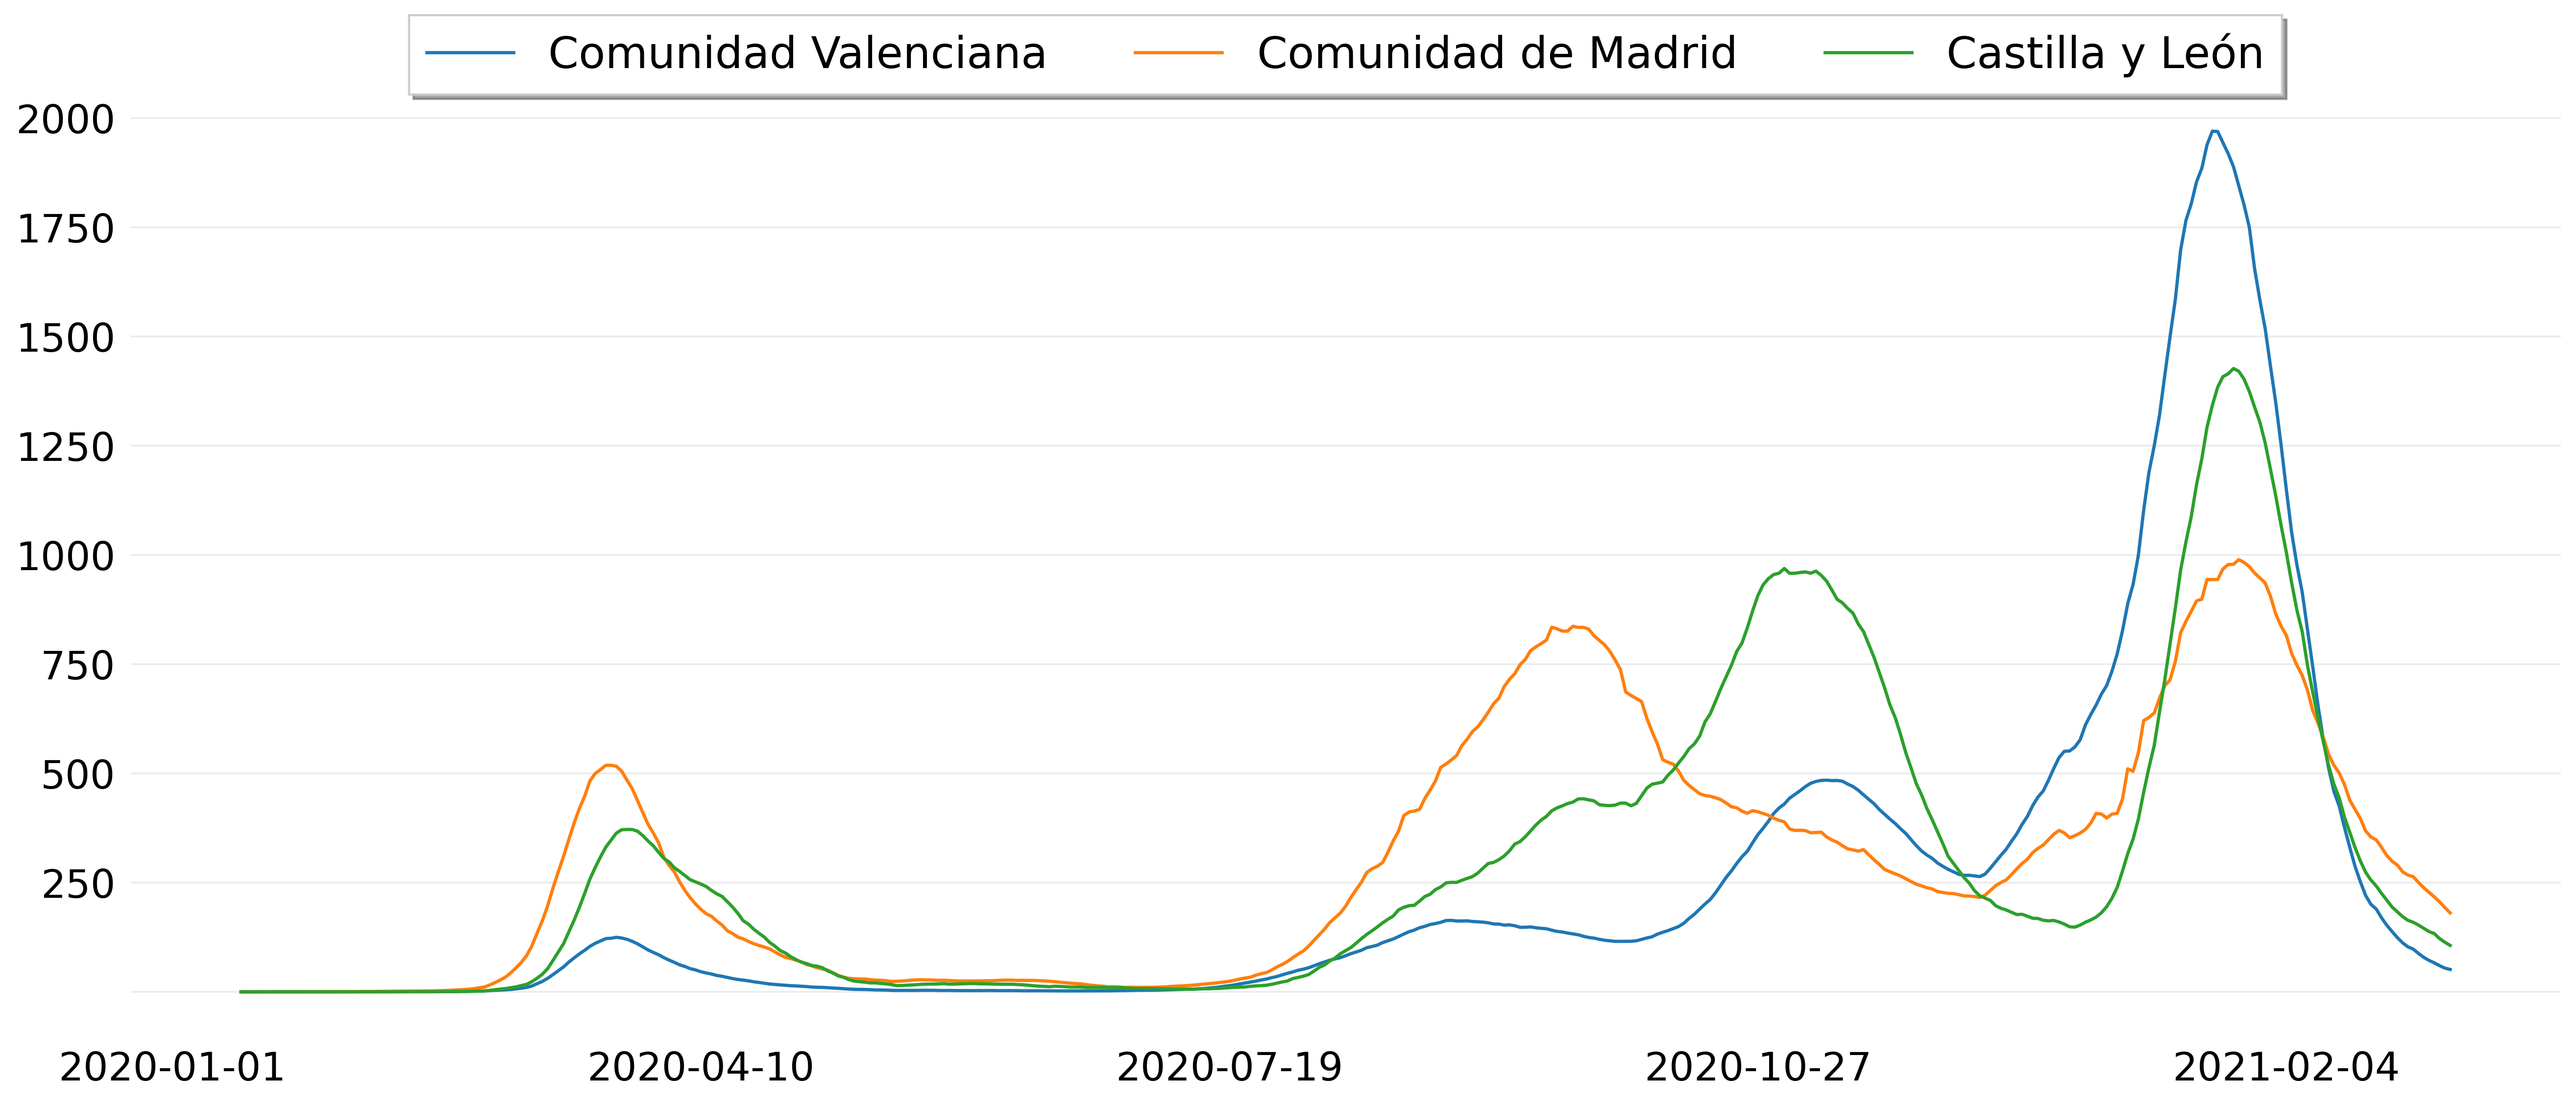

In [9]:
series.append('Castilla y León')

fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

for i in series:
    df2[i].plot()

nice_axes(ax)
plt.show()

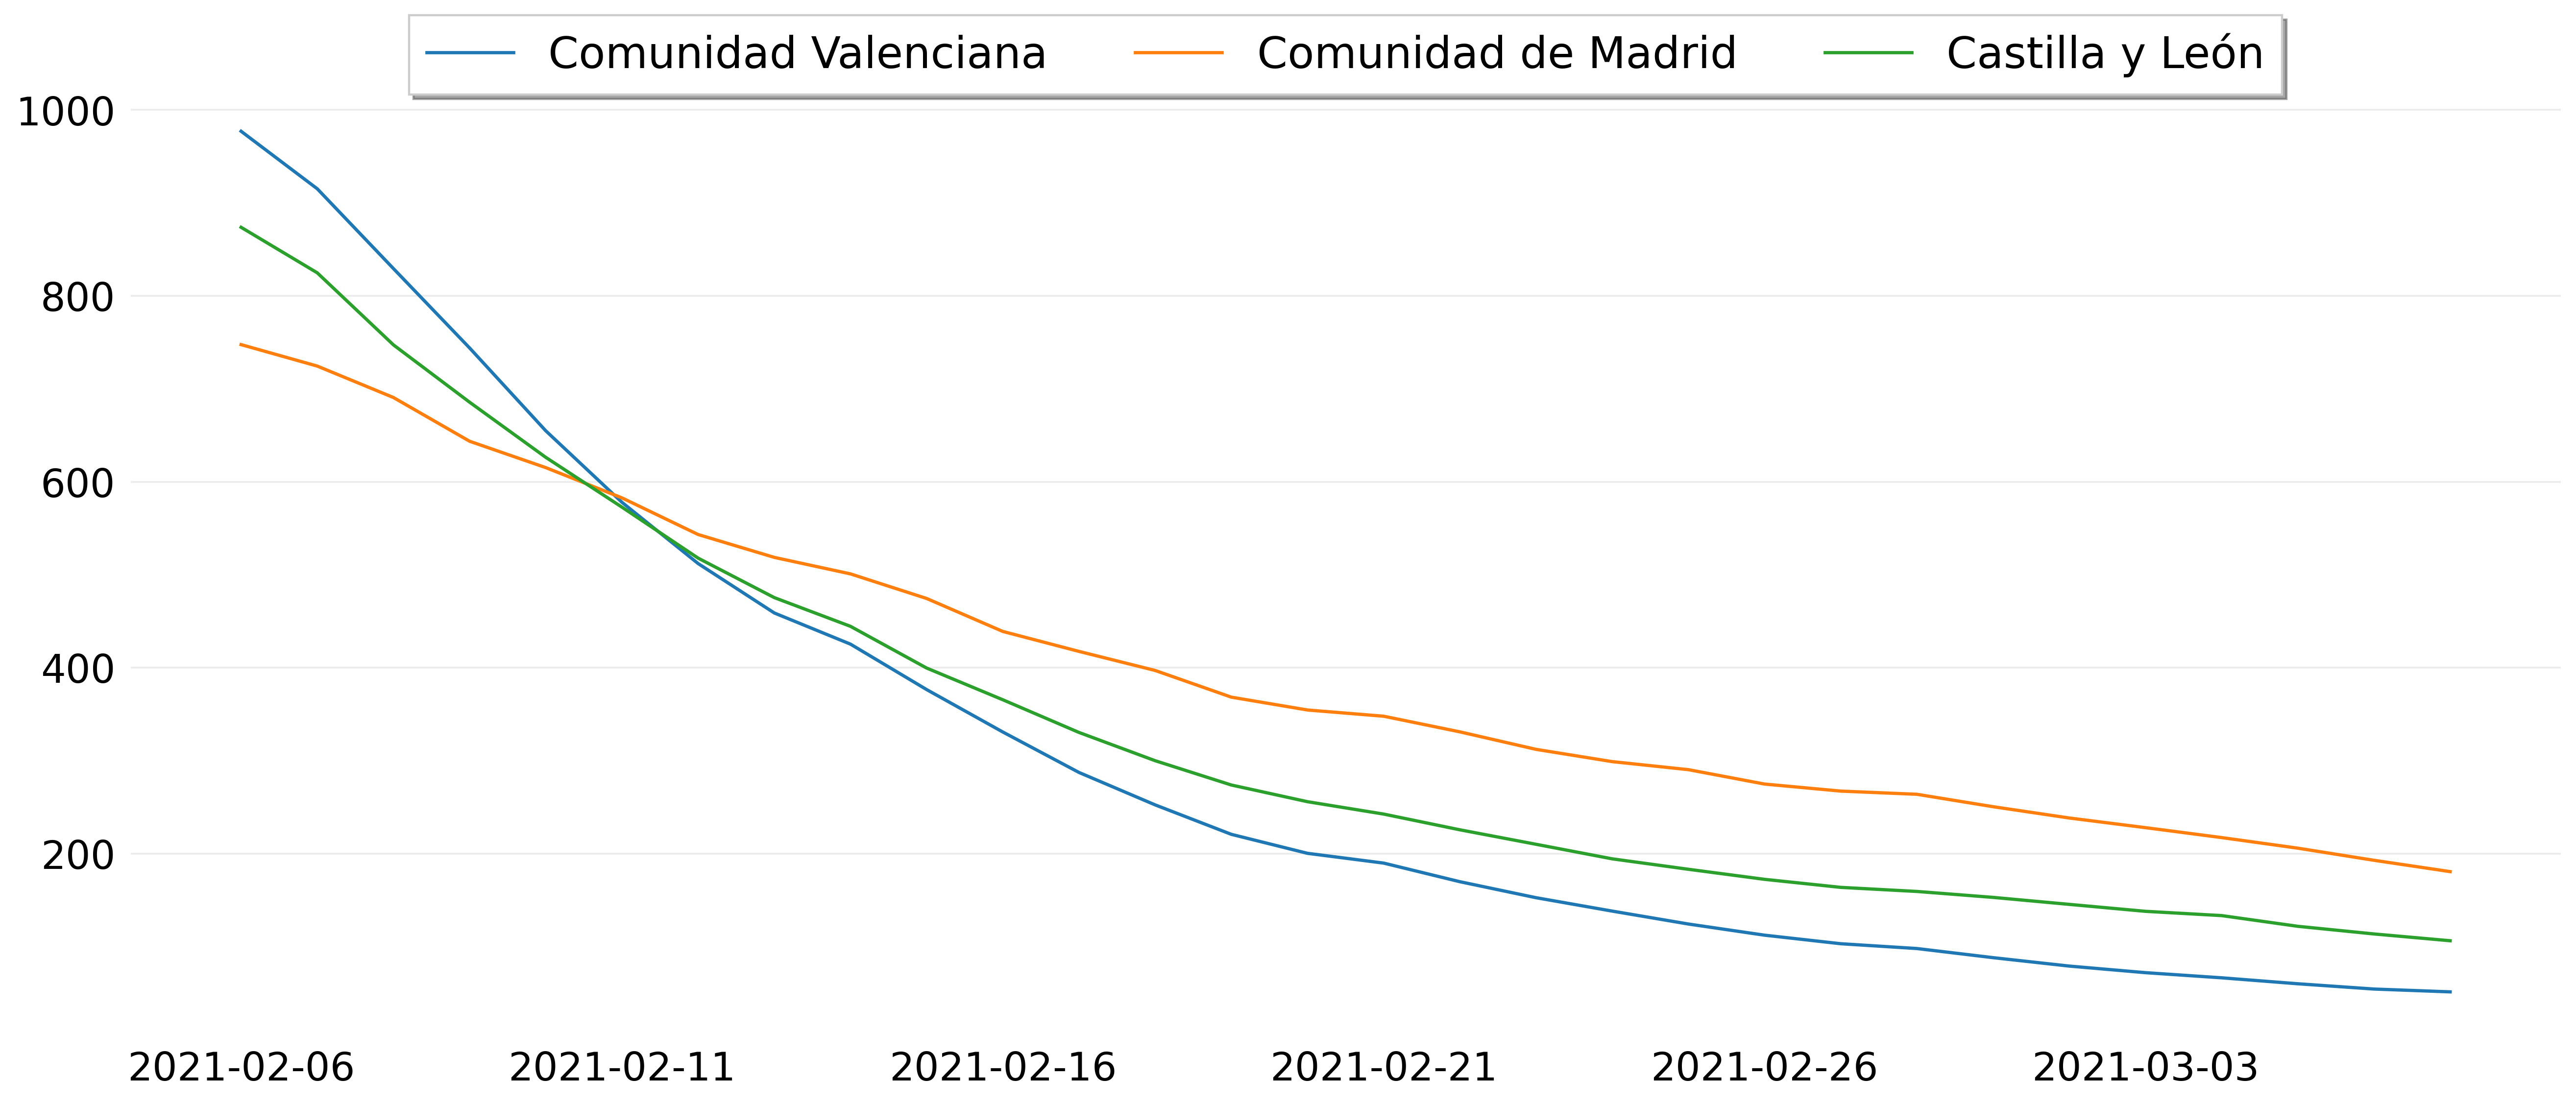

In [10]:


fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

for i in series:
    df2[-30:][i].plot()
    
nice_axes(ax)